<a href="https://colab.research.google.com/github/leorm2002/Realized-volatility-ML/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduzione del problema

# Introduzione
Il seguente progetto è basato sulla challenge kaggle [Optiver Realized Volatility Prediction](https://www.kaggle.com/competitions/optiver-realized-volatility-prediction)

La volatilità dei mercati finanziari rappresenta una misura fondamentale del rischio e dell'incertezza associati ai prezzi degli asset.

La volatilità realizzata è una misura della variabilità dei rendimenti di un asset nel tempo. Più specificamente, essa viene calcolata come la deviazione standard dei rendimenti di un asset durante un determinato periodo di tempo.


L'obiettivo è sviluppare un modello che in grado di stimare la volatilità realizzata per diverse azioni con un orizzonte temporale di 10 minuti, utilizzando *order book* e *trade log* dei precedenti 10 minuti.
Il modello inoltre dovrà predire solo risultati sulle azioni usate in fase di training

La challenge fornisce un dataset di training e prevede la submission del notebook per la valutazione con un dataset "nascosto" (con la garanzia di mantenere le stesse azioni utilizzate nel training, questo ci permette quindi di utilizzarle come parametro per il training). Non avendolo a disposizione si opterà per dividere il training set "originale" in un training set e un validation set, questo è possibile anche grazie alla grande quantità di dati disponibili nel dataset originale.  


In [236]:
!pip install swifter[notebook]
!pip install -U swifter[groupby]
!pip install lightgbm
!pip install fastapi

In [237]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
import swifter
from sklearn.model_selection import train_test_split
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import gc
import gdown
import pickle

In [238]:
TARGET_PATH = 'data/train.csv'
BOOK_PATH = 'data/book_train.parquet'
TRADE_PATH = 'data/trade_train.parquet'
DATA_URL = "1oRxakzOU7iAL4SFJYffAZuKF3oHSOuDX"
DATA_URL = f"https://drive.google.com/uc?id={DATA_URL}"
DOWLOADED_FILE = "data.zip"

# Modalita di funzionamento

# 0 carica dataset, preprocess, salvataggio dati preprocessati, addestramento, valutazione, salvataggio modelli
# 1 carica dati preprocessati addestramento, valutazione, salvataggio modelli
# 2 carica modelli preaddestrati, esponi endpoint per inferenza

MODE = 0


In [239]:
def mode(line, cell=None):
    '''Skips execution of the current line/cell if line evaluates to True.'''
    modes = [int(x) for x in (line.strip().split(","))]
    if MODE not in modes:
        return

    get_ipython().ex(cell)

def load_ipython_extension(shell):
    '''Registers the skip magic when the extension loads.'''
    shell.register_magic_function(mode, 'line_cell')

def unload_ipython_extension(shell):
    '''Unregisters the skip magic when the extension unloads.'''
    del shell.magics_manager.magics['cell']['skip']


load_ipython_extension(get_ipython())

## Caricamento dati

Il dataset è fornito separato in più file. Uno contente il valore della variabile target (volatilita realizzata a 10 minuti),l'id per ricondursi allo strumento finanziario e al momento preciso.
Un insieme di files, divisi per strumento finaziario contenenti 10 minuti di order book e trade effettuati

In [240]:
%%mode 0,1
import shutil

# scarichiamo
if not os.path.exists(DOWLOADED_FILE):
    print(f"File does not exist. Downloading...")
    gdown.download(DATA_URL, DOWLOADED_FILE, quiet=True)
else:
    print(f"File already exists")


File already exists


In [241]:
%%mode 0,1
target_folder = DOWLOADED_FILE.replace(".zip", "")
if os.path.exists(target_folder):
    shutil.rmtree(target_folder)
shutil.unpack_archive(DOWLOADED_FILE)


In [242]:
%%mode 0,1
target = pd.read_csv(TARGET_PATH)
#creiamo un id univoco che rappresenti il valore target di una determinata azione in un determinato momento
target['row_id'] = target['stock_id'].astype(str) + '-' + target['time_id'].astype(str)


In [243]:
%%mode 0
target.head()

Vediamo la struttura dell'order book e dei trade relativi alla stock con id = 0

In [244]:
%%mode 0
trade_example =  pd.read_parquet(TRADE_PATH + '/stock_id=0')
book_example = pd.read_parquet(BOOK_PATH + '/stock_id=0')

Significato delle colonne:


*   time_id: codice identificativo per il bucket temporale, divide in quanti di tempo da 10 minuti
*   seconds_in_bucket: secondi dall'inizio del bucket [0-600[
*   bid_price_1 buy price più competitivo
*   ask_price_1 sell price più competitivo
*   bid_price_2 secondo buy price più competitivo
*   ask_price_2 secondo sell price più competitivo
*   bid_size_1 numero di azioni per bid_price_1
*   ask_size_1 numero di azioni ask_price_1
*   bid_size_2 numero di azioni bid_price_2
*   ask_size_2 numero di azioni ask_price_2

Esempio, una riga con time_id = 2 e seconds_in_bucket=300 rappresenta il momentod dopo 25 minuti dall'inizio del primo interallo


In [245]:
%%mode 0
book_example.head()

In [246]:
%%mode 0
numero_tempi = len(book_example["time_id"].unique())
print("Numero di intevalli temporali:", numero_tempi)

Numero di intevalli temporali: 3830


Significato delle colonne:
*   time_id codice identificativo per il bucket temporale
*   seconds_in_bucket secondi dall'inizio del bucket (0 based)
*   price: prezzo a cui è avvenuto lo scambio
*   size: numero di azioni scambiate
*   oder_count: numero di ordini
Le prime due colonne referenziano un particolare order book

In [247]:
%%mode 0
trade_example.head()

Procediamo a quindi a caricare tuatti i dati in due data frame, l'informazione relativa all'azione relativa al book non è presente nei dati ma dipende dalla cartella, scriviamo quindi una funzione che ci permetta di arricchire i dati caricati

In [248]:
%%mode 0
def load_and_enrich(folder : str, sub_folder : str, stock_range: list):
    path = os.path.join(folder, sub_folder)
    stock_id = sub_folder.split('=')[-1]
    stock_id = int(stock_id)
    if stock_range and stock_id not in stock_range:
        return None
    try:
        parquet_file = os.listdir(path)[0]
        parquet_file = os.path.join(path, parquet_file)
        df = pd.read_parquet(parquet_file)
        df.loc[:,'stock_id'] = stock_id
        return df
    except:
      print(sub_folder)

#carica, per ogni sotto cartella contenuta nella cartella passata come parametro il file parquet contenuto
def load_folder(folder: str, max_num : int = None):
    folders = os.listdir(folder)
    stock_range = None
    df = pd.DataFrame()
    dfs = []
    if max_num:
      stock_range = [x for x in range(max_num)]
    for subfolder in folders:
      out = load_and_enrich(folder, subfolder, stock_range)
      if out is None:
        continue
      dfs.append(out)
      #df = pd.concat([df, out])

    return pd.concat(dfs)

A questo punto carichiamo l'order book della prima azione

In [249]:
%%mode 0
books = load_folder(BOOK_PATH, 1)

In [250]:
%%mode 0
orders = load_folder(TRADE_PATH, 1)

## Analisi iniziale

In [251]:
%%mode 0
books

In [252]:
%%mode 0
orders.head()

In [253]:
%%mode 0
lunghezza_serie = books.groupby('stock_id')['time_id'].nunique().unique()
print("Serie temporali per ogni azione:", lunghezza_serie)
# vediamo come ogni serie abbia la stessa lunghezza

Serie temporali per ogni azione: [3830]


Vediamo ora un l'order book per una singola azione per un singolo bucket e le informazioni relative allo scambio

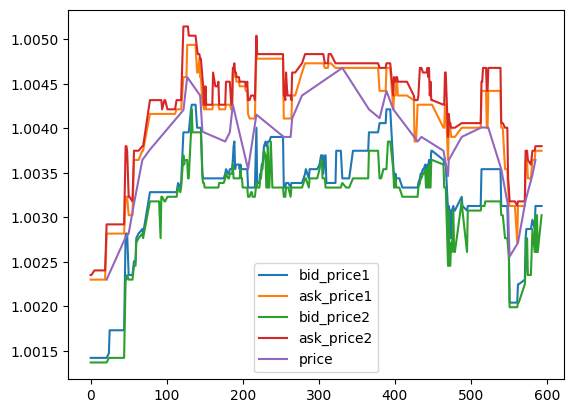

In [254]:
%%mode 0
stock = 0
time = 5
key = "seconds_in_bucket"
order_book = books[(books['stock_id'] == stock) & (books['time_id'] == time)]
trade_log = orders[(orders['stock_id'] == stock) & (orders['time_id'] == time)]
samples = ["bid_price1", "ask_price1", "bid_price2", "ask_price2"]
# plottiamo il valore delle serie
for sample in samples:
    plt.plot(order_book[key],order_book[sample], label=sample)
plt.plot(trade_log[key],trade_log["price"], label="price")
plt.legend()
plt.show()
trade_log.head()

Confrontiamo ora il volume degli scambi contro il volume degli ordini

In [255]:
%%mode 0
to_plot = books.merge(orders, on=["time_id", "seconds_in_bucket", "stock_id"], how="left")
to_plot["trade_ratio"] = to_plot["size"] * 2 / (to_plot["ask_size1"] + to_plot["bid_size1"] + to_plot["bid_size2"] + to_plot["ask_size2"])
to_plot["trade_ratio"].describe()

## Feature engineering

L'obbiettivo del modello è predire la Realized Volatility di un azione con una finestra temporale di 10 minuti. La Realized Volatility σ è definita come la radice quadrata della somma dei quadrati del logaritmo dei rendimenti ovvero:
  
$$
\sigma = \sqrt{\sum_{t}{\log(\frac{S_{t-1}}{S_{t}})^2}}
$$
Dove $S_t$ è il valore del prodotto all'istante t.
Usiamo WAP (weighted average price) per calcolare il prezzo di uno strumento all'istante $t$ secondo la formula:
$$
WAP = \frac
{BidPrice_1 \cdot AskSize_1 + AskPrice_1 \cdot BidSize_1}
{BidSize_1 + AskSize_1}
$$


Iniziamo a studiare ed introdurre indicatori che ci permettano di sintetizzare le informazioni presenti in ogni order book a ogni secondo

In [256]:
%%mode 0,2
def log_return(list_stock_prices, column="wap"):
    log_returns = np.log(list_stock_prices[column]).diff()
    col = column + "_log_return"
    list_stock_prices[col] = log_returns
    return list_stock_prices

def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

def wap1(df):
    return (df['bid_price1'] * df['ask_size1']+df['ask_price1'] * df['bid_size1'])  / (df['bid_size1']+ df['ask_size1'])

def wap2(df):
    return (df['bid_price2'] * df['ask_size2']+df['ask_price2'] * df['bid_size2'])  / (df['bid_size2']+ df['ask_size2'])

def wap_balance(df):
    return abs(df["wap1"] - df["wap2"])

def relativeBidAskSpread1(df):
    # Da un indicazione della liquidita dell'asset relativa
    return (df["ask_price1"] - df["bid_price1"]) / ((df["ask_price1"] + df["bid_price1"])/2)

def relativeBidAskSpread2(df):
    # Da un indicazione della liquidita dell'asset relativa
    return (df["ask_price2"] - df["bid_price2"]) / ((df["ask_price2"] + df["bid_price2"])/2)

def orderImbalance(df):
    # Da un indicazione della liquidita dell'asset in termini di quantita
    return (df["bid_size1"] - df["ask_size1"]) / (df["bid_size1"] + df["ask_size1"])

def volume(df):
    return df["bid_size1"] + df["ask_size1"] + df["bid_size2"] + df["ask_size2"]

def volume_imbalance(df):
    return abs((df["bid_size1"] + df["bid_size2"]) - (df["ask_size1"] + df["ask_size2"]))

def bid_ask_spread(df):
    return abs(df['bid_price1'] - df['bid_price2'] - (df['ask_price1'] - df['ask_price2']))

def log_return_wap1(list_stock_prices):
    return log_return(list_stock_prices, column="wap1")

def log_return_wap2(list_stock_prices):
    return log_return(list_stock_prices, column="wap2")

Creiamo ora le procedure che ci permettono di sintetizzare le feature in un singolo record rappresentante il bucket su cui faremo la previsione

In [257]:
%%mode 0,2
#definiamo le operazioni da effettuare su ogni feture per aggregare
feature_operations_dict = {
        'wap1': [np.sum, np.std],
        'wap2': [np.sum, np.std],
        'wap1_log_return': [realized_volatility],
        'wap2_log_return': [realized_volatility],
        'relativeBidAskSpread1':[np.sum, np.max],
        'relativeBidAskSpread2':[np.sum, np.max],
        'order_imbalance':[np.sum, np.max],
        'volume':[np.sum, np.max],
        'volume_imbalance':[np.sum, np.max],
        "bid_ask_spread":[np.sum,  np.max],
}

feature_operations_time_dict = {
    'wap1_log_return': [realized_volatility],
    'wap2_log_return': [realized_volatility]
}

feature_operations_log_dict = {
      'price_log_return':[realized_volatility],
      'size':[np.sum, np.max, np.min],
      'order_count':[np.sum,np.max],
      'volume':[np.sum,np.max,np.min]
}

feature_operations_log_time_dict = {
    'price_log_return':[realized_volatility],
    'size':[np.sum],
    'order_count':[np.sum],
  }

windows = [150, 300, 450]

In [258]:
%%mode 0,2
def apply_window(bucket, window, operations, add_suffix : bool = True):
    df_feature = bucket[bucket['seconds_in_bucket'] >= window].groupby(['time_id']).agg(operations).reset_index()
    df_feature.columns = ['_'.join(col) for col in df_feature.columns]
    # Add a suffix to differentiate windows
    if add_suffix:
        df_feature = df_feature.add_suffix('_' + str(window))

    return df_feature

def apply_windows(bucket, windows, operationsAll, operationsSub):
    df = apply_window(bucket, 0, operationsAll, False)
    for window in windows:
        df_feature = apply_window(bucket, window, operationsSub)
        key = 'time_id__' + str(window)
        df = df.merge(df_feature, how='left', left_on='time_id_', right_on=key)
        df.drop(key, axis=1, inplace=True)
    return df

In [259]:
%%mode 0,2
def add_features_to_book(book):
    book['wap1'] = wap1(book)
    book['wap2'] = wap2(book)

    # log return wap1
    book = book.swifter.groupby(['time_id']).apply(log_return_wap1).reset_index(drop=True)
    book = book[~book['wap1_log_return'].isnull()] # rimuoviamo t0

    # log return wap2
    book = book.swifter.groupby(['time_id']).apply(log_return_wap2).reset_index(drop=True)
    book = book[~book['wap2_log_return'].isnull()] # rimuoviamo t0

    book['wap_diff'] = wap_balance(book)
    book["relativeBidAskSpread1"] = relativeBidAskSpread1(book)
    book["relativeBidAskSpread2"] = relativeBidAskSpread2(book)
    book["order_imbalance"] = orderImbalance(book)
    book["volume"] = volume(book)
    book["volume_imbalance"] = volume_imbalance(book)
    book["bid_ask_spread"] = bid_ask_spread(book)
    return book


def add_features_to_log(log):
    log = log.swifter.groupby(["time_id"]).apply(lambda x: log_return(x, column="price")).reset_index(drop=True)
    log = log[~log['price_log_return'].isnull()] # rimuoviamo t0
    log["volume"] = log["price"] + log["price"]

    return log


In [260]:
%%mode 0,2
def process(books, logs):
    books = add_features_to_book(books)
    books = apply_windows(books, windows, feature_operations_dict, feature_operations_time_dict)

    logs = add_features_to_log(logs)
    logs = apply_windows(logs, windows, feature_operations_log_dict, feature_operations_log_time_dict)
    # merge logs on books
    ret = books.merge(logs, on="time_id_", how="left")
    return ret


Applichiamo quindi ai nostri order book le trasformazioni

In [261]:
%%mode 0
def load_and_enrich(folder : str, trade_logs_folder : str, sub_folder : str, stock_range: list):
    books_path = os.path.join(folder, sub_folder)
    trades_path = os.path.join(trade_logs_folder, sub_folder)

    stock_id = sub_folder.split('=')[-1]
    stock_id = int(stock_id)
    if stock_range and stock_id not in stock_range:
        return None
    try:
        books_parquet_file = os.listdir(books_path)[0]
        books_parquet_file = os.path.join(books_path, books_parquet_file)

        trades_parquet_file = os.listdir(trades_path)[0]
        trades_parquet_file = os.path.join(trades_path, trades_parquet_file)

        ret = process(pd.read_parquet(books_parquet_file), pd.read_parquet(trades_parquet_file))
        ret['stock_id'] = stock_id
        print("Elaborated ", stock_id)
        return ret
    except Exception as e:
      print(e)

#carica, per ogni sotto cartella contenuta nella cartella passata come parametro il file parquet contenuto
def load_folder(order_books_folder: str, trade_logs_folder: str, max_num : int = None):
    folders = os.listdir(order_books_folder)
    stock_range = None
    df = pd.DataFrame()
    dfs = []
    if max_num:
      stock_range = [x for x in range(max_num)]
    i = 0
    for subfolder in folders:
      out = load_and_enrich(order_books_folder, trade_logs_folder, subfolder, stock_range)
      if out is None:
        continue
      dfs.append(out)
      i += 1
      print(i, "/", max_num)

    return pd.concat(dfs)


In [262]:
%%mode 0,1
def save(df, name):
  df.to_parquet(name)
def load(name):
  df = pd.read_parquet(name)
  return df

name = "df20.parquet"


In [264]:
%%mode 0
df = load_folder(BOOK_PATH, TRADE_PATH)
save(df, name)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Elaborated  19
1 / None


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Elaborated  10
2 / None


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Elaborated  18
3 / None


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Elaborated  4
4 / None


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Elaborated  15
5 / None


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Elaborated  17
6 / None


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Elaborated  11
7 / None


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Elaborated  0
8 / None


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Elaborated  6
9 / None


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Elaborated  3
10 / None


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Elaborated  13
11 / None


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Elaborated  7
12 / None


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Elaborated  2
13 / None


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Elaborated  16
14 / None


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Elaborated  8
15 / None


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Elaborated  14
16 / None


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Elaborated  5
17 / None


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Elaborated  9
18 / None


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Elaborated  1
19 / None


## Analisi delle feture introdotte e valutazioni

In [197]:
%%mode 0
print(df.isna().sum())

Vediamo come alcune righe hanno feature mancanti (questo è derivato dalla mancanza di scambi in parte dei bucket temporali) rimpiazziamo questi NaN con zero visto che tutte le misure interessate ha senso siano 0 in caso di mancanza di dati

In [198]:
%%mode 0
df.fillna(0, inplace=True)

In [199]:
%%mode 0
print(df.isna().sum())

In [200]:
%%mode 1
df = load(name)

## Approccio naive (idea presa da esempio kaggle)
La volatilità tende ad essere autocorrelata, possiamo creare un modello base che predica la correlazione stessa dei dati passati in input, sarà un benchmarck iniziale per valutare l'accuratezza di modelli che andremo a produrre

In [201]:
%%mode 0,1
from sklearn.metrics import r2_score
    # usiamo come metriche R2 e RPMSE
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))
def evaluate(predictions, target):
  df_joined = predictions.merge(target, on = "row_id", how="left")
  R2 = round(r2_score(y_true = df_joined['target'], y_pred = df_joined['pred']),3)
  RMSPE = round(rmspe(y_true = df_joined['target'], y_pred = df_joined['pred']),3)
  print(f'Performance of the naive prediction: R2 score: {R2}, RMSPE: {RMSPE}')

def realized_volatility_per_time_id(df_book_data):
    prediction_column_name = 'pred'
    columns = ['time_id_','wap1_log_return_realized_volatility']
    df_realized_vol_per_stock = df_book_data[columns]
    df_realized_vol_per_stock = df_realized_vol_per_stock.rename(columns = {'wap1_log_return_realized_volatility':prediction_column_name})
    stock_id = str(df_book_data['stock_id'].unique()[0])
    df_realized_vol_per_stock['row_id'] = df_realized_vol_per_stock['time_id_'].apply(lambda x:stock_id + '-' + str(x))
    return df_realized_vol_per_stock[['row_id',prediction_column_name]]
def realized_volatility_naive(df_book_data):
    #raggruppo applico la funzione sopra a ogni stock
    return df_book_data.groupby(['stock_id']).apply(realized_volatility_per_time_id).reset_index(drop=True)

In [202]:
%%mode 0,1
pred = realized_volatility_naive(df)

In [203]:
%%mode 0,1
evaluate(pred, target)

## Divisione del data-set in training e test set

In [204]:
%%mode 0,1
#creiamo l'id per ricondurci alle previsioni
df["row_id"] = df["stock_id"].astype(str) + "-" + df["time_id_"].astype(str)
#prendiamo le previsioni relative solo alle azioni e ai bucket temporali che abbiamo ottenuto
y = df.merge(target, on="row_id", how="left")["target"]
x = df.drop(columns=["time_id_", "row_id"], inplace=False)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=3107, test_size = 0.2)


## Funzioni di utilita comuni

In [205]:
%%mode 0,1
def evaluate(predictions, target):
  R2 = round(r2_score(y_true = target, y_pred = predictions),3)
  RMSPE = round(rmspe(y_true = target, y_pred = predictions),3)
  print(f'Performance: R2 score: {R2}, RMSPE: {RMSPE}')
  return R2, RMSPE

def plot_feature_importance(model):
    print("Elenco delle feature valutate dal modello in ordine di importanza")
    # Feature Importances
    importances = model["regressor"].best_estimator_.feature_importances_
    indices = np.argsort(importances)[::-1]
    features = model["preprocessor"].get_feature_names_out()

    # Plotting the feature importances
    plt.figure(figsize=(10, 10))
    plt.title("Feature Importances")
    plt.barh(range(len(features)), importances[indices], align="center")
    plt.yticks(range(len(features)), features[indices])
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
    plt.show()

def plot_predictions_vs_real(predictedd, reall, n):
    print(f"Elenco dei primi {n} valori della serie predetta contro i valori reali")
    predicted = predictedd[:n]
    real = reall[:n]
    plt.figure(figsize=(10, 6))

    # Plotting the real data as points
    plt.scatter(range(len(real)), real, label="Real", color="blue", marker='o')

    # Plotting the predicted data as points
    plt.scatter(range(len(predicted)), predicted, label="Predicted", color="red", marker='x')

    # Adding labels and title
    plt.xlabel("Data Points")
    plt.ylabel("Values")
    plt.title("Predicted vs Real Data Points")

    # Adding a legend to differentiate between predicted and real data
    plt.legend()

    # Adding a grid for better readability
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def evaluate_model(pipeline, y, target, evaluate_importance = True):
  predictions = pipeline.predict(y)
  evaluate(predictions, target)
  if evaluate_importance:
      print()
      plot_feature_importance(pipeline)
  print()
  plot_predictions_vs_real(predictions, target, 50)

In [206]:
%%mode 0,1
def get_preprocessing_pipeline(grid_search, one_hot_encode_stocks = False):
    # one hot encoding sull'id dell'azione
    transformer = [("stock_id", OneHotEncoder(handle_unknown="ignore"), ["stock_id"])] if one_hot_encode_stocks else []

    return Pipeline(
    steps=[
        ("preprocessor", ColumnTransformer( transformer, remainder='passthrough')),
        #('scaler', StandardScaler()),
        ("regressor", grid_search)
    ])

def my_scorer(model, x, y):
  y_pred = model.predict(x)
  return rmspe(y, y_pred)


## Ridge e kernel ridge Regression

In [207]:
%%mode 0,1
from sklearn.kernel_ridge import KernelRidge
params = {
    "alpha": [1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1],
    "kernel": ["linear", "poly", "rbf"],
    "degree": [2, 3]
}
params = {}
#gs = GridSearchCV(estimator=KernelRidge(), cv=2, param_grid=params, scoring="neg_mean_squared_error", n_jobs=-1, verbose=1)
#gs = get_preprocessing_pipeline(KernelRidge(alpha=20, kernel="poly", degree=5, n_job = -1))

#gs.fit(x_train, y_train)

In [208]:
%%mode 0,1
#evaluate_model(gs, x_test, y_test)

## Lasso Regression

In [209]:
%%mode 0,1
from sklearn.linear_model import Lasso
values = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

lasso = GridSearchCV(estimator=Lasso(), cv=2, param_grid=dict(alpha=values), scoring="neg_mean_squared_error", n_jobs=-1, verbose=1)
lasso = get_preprocessing_pipeline(lasso)
lasso.fit(x_train, y_train)


In [210]:
%%mode 0,1
evaluate_model(lasso, x_test, y_test, False)

## Random Forest

In [211]:
%%mode 0,1
def get_random_forest(params, x, y):
  rf = RandomForestRegressor(random_state=3107, max_features="sqrt", n_jobs=-1, verbose = 0)
  gs = GridSearchCV(estimator=rf, cv=2, param_grid=params, scoring='neg_mean_squared_error',n_jobs=1, verbose=10)
  gs = get_preprocessing_pipeline(gs)
  gs.fit(x, y)
  return gs

In [212]:
%%mode 0,1
no_params_rf = get_random_forest({}, x_train, y_train)

In [213]:
%%mode 0,1
evaluate_model(no_params_rf, x_test, y_test)

In [214]:
%%mode 0,1
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
rf_gs = get_random_forest(param_grid, x_train, y_train)

## XGBoost

In [215]:
%%mode 0,1
from xgboost import XGBRegressor
xgbm = XGBRegressor(objective='reg:squarederror', reg_alpha=0.0, reg_lambda=1.0, n_estimators=200, verbose_eval=True)
xgbm = get_preprocessing_pipeline(xgbm)
xgbm.fit(x_train, y_train)

In [216]:
%%mode 0,1
evaluate_model(xgbm, x_test, y_test, False)

## LGBM

In [217]:
%%mode 0,1
from sklearn.model_selection import RandomizedSearchCV
def get_model(params, x ,y):
    gs = RandomizedSearchCV(
            estimator=LGBMRegressor(random_state=3107, n_jobs=1, verbose = 0),
            param_distributions=params,
            cv=3,
            n_iter=40,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            random_state=3107,
            refit=True,
            verbose = 10) # necessaria da documentazione quando utilizziamo la grid search all'interno di una
    gs = get_preprocessing_pipeline(gs)
    gs.fit(x, y)
    return gs

In [218]:
%%mode 0,1
lgbm_no_params = get_model({}, x_train, y_train)

In [219]:
%%mode 0,1
evaluate_model(lgbm_no_params, x_test, y_test)#Performance: R2 score: 0.811, RMSPE: 0.26

In [220]:
%%mode 0,1
param_grid = {
    'num_leaves': sp_randint(20, 150),
    'max_depth': sp_randint(-1, 50),
    'learning_rate': sp_uniform(0.01, 0.3),
    'n_estimators': sp_randint(100, 1000),
    'min_child_samples': sp_randint(10, 100),
    'reg_alpha': sp_uniform(0.0, 1.0),
    'reg_lambda': sp_uniform(0.0, 1.0)
}

In [221]:
%%mode 0,1
lgbm_rs = get_model(param_grid, x_train, y_train)

In [222]:
%%mode 0,1
evaluate_model(lgbm_rs, x_test, y_test)

In [223]:
%%mode 0,1
pd.DataFrame(lgbm_rs["regressor"].cv_results_).sort_values(by="rank_test_score", ascending=True)

## Valutazione dei modelli
andiamo a valutare la performance dei vari modelli prodotti

In [224]:
%%mode 0,1
rf_gs = no_params_rf

In [225]:
%%mode 0,1
models_dict = {
 "lasso" : lasso,
 "rf" : rf_gs,
 "xgb" : xgbm,
 "lgbm" : lgbm_rs,
}

In [226]:
%%mode 0
def save_models(models_dict, folder):
  if not os.path.exists(folder):
    os.makedirs(folder)
  for model_name, model in models_dict.items():
    with open(f"{folder}/{model_name}.pkl", "wb") as f:
      pickle.dump(model, f)

In [227]:
%%mode 0
save_models(models_dict, "models")

In [228]:
%%mode 0,1
def create_evaluation_dict(x, y, models_dict):
    results = []
    for model_name, model in models_dict.items():
        print(f"Evaluating {model_name}")
        pred = model.predict(x)
        R2, RMSPE = evaluate(pred, y)
        results.append(
          {"Model": model_name,"R2": R2, "RMSPE": RMSPE}
        )
    #converts results to df
    results = pd.DataFrame(results)
    results = results.sort_values(by="RMSPE", ascending=True)
    return results
def plot_results_hist(df):

  pos = np.arange(len(df['Model']))
  bar_width = 0.2
  fig, ax = plt.subplots(figsize=(8, 4))

  # Plotting R2 values
  bars1 = ax.barh(pos, df['R2'], bar_width, label='R2', color='orange')

  # Plotting RMPSE values
  bars2 = ax.barh(pos + bar_width, df['RMSPE'], bar_width, label='RMSPE', color='green')

  ax.set_yticks(pos + bar_width / 2)
  ax.set_yticklabels(df['Model'])
  ax.set_xlabel('Value')
  ax.set_title('R2 and RMSPE per modello')
  ax.legend()
  plt.show()

def plot_results_num(df):

    # Create a figure and an axis
    fig, ax = plt.subplots(figsize=(6, 2))

    # Hide the axes
    ax.axis('tight')
    ax.axis('off')

    # Create the table
    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

    # Show the plot
    plt.show()

In [229]:
%%mode 0,1
results = create_evaluation_dict(x_test, y_test, models_dict)

In [230]:
%%mode 0,1
plot_results_num(results)

In [231]:
%%mode 0,1
plot_results_hist(results)

## Esposizione modello via rest
Iniziamo definendo il modello dati che esporremo via api

In [232]:
%%mode 2
from typing import List
from pydantic import BaseModel, Field, validator, root_validator
from enum import Enum

class BookEntry(BaseModel):
    seconds_in_bucket: int
    bid_price1: float
    ask_price1: float
    bid_price2: float
    ask_price2: float
    bid_size1: float
    ask_size1: float
    bid_size2: float
    ask_size2: float

class TradeEntry(BaseModel):
    seconds_in_bucket: int
    price: float
    size: float
    order_count: float

class Model(str, Enum):
    lasso = "lasso"
    rf = "rf"
    xgb = "xgb"
    lgbm = "lgbm"

class Req(BaseModel):
    book: List[BookEntry]
    trades: List[TradeEntry]
    stock_id: int
    model: str

In [233]:
!pip install uvicorn

In [234]:
!pip install fastapi nest-asyncio pyngrok uvicorn
!ngrok authtoken 2kZ0J3lomZ0MnlAcGwwErVuswvc_6jb7mBwjWqZcedxcv99eZ

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [235]:
%%mode 2
from fastapi import FastAPI
import asyncio
import uvicorn
from pyngrok import ngrok
import time
import nest_asyncio

app = FastAPI()
models = {}

def load_models_(folder):
  models_dict = {}
  for model_name in os.listdir(folder):
      with open(f"{folder}/{model_name}", "rb") as f:
          models_dict[model_name.split(".")[0]] = pickle.load(f)
  return models_dict

#at startup load all model in the folder models
@app.on_event("startup")
def load_models():
  global models
  models = load_models_("models")
  print("Loaded models")
  print(models.keys())

def to_dict(data):
  return  [item.dict() for item in data]

@app.post("/predict")
async def predict(request: Req):
    global book
    model = request.model
    model = models[model]
    book = pd.DataFrame(to_dict(request.book))
    trade = pd.DataFrame(to_dict(request.trades))
    #add mock time id
    book["time_id"] = 0
    trade["time_id"] = 0
    df = process(book, trade)
    # add a stock_id column
    df["stock_id"] = request.stock_id
    pred = model.predict(df)[0]
    print(pred)
    return {"predicted_volatility": pred}


@app.get("/")
async def root():
    return {"message": "Running"}

ngrok_tunnel = ngrok.connect(8000)
print('Public URL:', ngrok_tunnel.public_url)
nest_asyncio.apply()
uvicorn.run(app, port=8000)

<string>:19: DeprecationWarning: 
        on_event is deprecated, use lifespan event handlers instead.

        Read more about it in the
        [FastAPI docs for Lifespan Events](https://fastapi.tiangolo.com/advanced/events/).
        
INFO:     Started server process [87392]
INFO:     Waiting for application startup.


Public URL: https://49aa-35-194-195-53.ngrok-free.app


INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


Loaded models
dict_keys(['lasso', 'lgbm', 'rf', 'xgb'])


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [87392]
